This notebook defines the baseline model and evaluates it

In [1]:
# Load libraries

import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import pretty_midi

In [99]:
# User parameters

path = os.getcwd()
midi_path = os.getcwd()

sampling_rate = 16000 # 22050 is default, 16000 is to match the paper; sampling rate for WAV files
num_freq_bins = 229
n_fft = 2048 # default value
threshold = 0.25 # keep top 25% of sounds

In [2]:
def accuracy(prediction, label, window_size = 1):
  #initialize count
  count = 0
  #check if window_size is an integer
  #convert each 2D tensor into a 2D numpy array
  pred_np = prediction
  label_np = label 
  #check that the dimensions of the prediction and the label are the same
  if pred_np.shape != label_np.shape:
    print("Error- prediction and label sizes don't match!")
    return
  #check that window_size is a positive odd integer 
  if window_size <= 0:
    print("Error- window_size is not positive!")
    return
  elif isinstance(window_size, int) != True:
    print("Error- window_size is not an integer!")
    return
  elif isinstance(window_size, int) == True:
    if window_size % 2 == 0:
      print("Error- window_size is not odd!")
      return
  #find the number of frames of each file
  col = pred_np.shape[1]
  #check if the values in each column of the prediction are the same for the label within the window_size
  for i in range(col):
    #case where window_size is out of bounds (beginning case)
    if i >=0 and i < int(window_size/2):
      lower_lim = 0
      upper_lim = i + int(window_size/2)
    #case where window_size is out of bounds (end case)
    elif i >= col - int(window_size/2) and i <= col:
      lower_lim = i - int(window_size/2)
      upper_lim = col - 1
    else:
      lower_lim = i - int(window_size/2)
      upper_lim = i + int(window_size/2)
    window_arr = label_np[:, lower_lim:upper_lim + 1]
    if (np.transpose(pred_np)[i:i+1].tolist()[0] in np.transpose(window_arr).tolist()) == True: 
      count += 1
  return count/col

In [117]:
# https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies

# only keep the frequencies of the song which are playable on the piano

index_to_freq = librosa.fft_frequencies(sr=sampling_rate, n_fft=n_fft)
for i, f in enumerate(index_to_freq):
    if f > (25.96+27.5)/2: # averaged A0 with midi note below
        lowest_i = i
        break
for i in range(len(index_to_freq)):
    if index_to_freq[i+1] > (4186.01+4434.92)/2: # averaged C8 with C#8
        highest_i = i
        break

In [118]:
piano_notes_to_freq = [25.96, 27.5, 29.14, 30.87, 32.7, 34.65, 36.71, 38.89, 41.2, 43.65, 46.25, 49, 51.91, 55,
                       58.27, 61.74, 65.41, 69.3, 73.42, 77.78, 82.41, 87.31, 92.5, 98, 103.83, 110, 116.54,
                       123.47, 130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185, 196, 207.65, 220, 233.08,
                       246.94, 261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392, 415.3, 440, 466.16,
                       493.88, 523.25, 554.37, 587.33, 622.25, 659.26, 698.46, 739.99, 783.99, 830.61, 880, 932.33,
                      987.77, 1046.5, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760,
                      1864.66, 1975.53, 2093, 2217.46, 2349.32, 2489.02, 2637.02, 2793.83, 2959.96, 3135.96,
                      3322.44, 3520, 3729.31, 3951.07, 4186.01, 4434.92]
piano_note_bounds = []
for i in range(len(piano_notes_to_freq)-1):
    piano_note_bounds.append((piano_notes_to_freq[i]+piano_notes_to_freq[i+1])/2)

In [103]:
frame_acc_1 = 0 # window size of 1
frame_acc_5 = 0 # window size of 5
frame_acc_11 = 0 # window size of 11
frame_acc_123 = 0 # window size of 247
elem_acc = 0 # element accuracy
file_num = 0

for file in tqdm(os.listdir(path)):

    if file.endswith('.wav'):
    
        # Load WAV file
        audio, _ = librosa.core.load(os.path.join(path,file), sr=sampling_rate)
        
        # Compute spectrogram on each partition of the song
        spectrogram = np.abs(librosa.stft(audio[:audio.shape[0]//2])) # use first four seconds
    
        # only keep frequencies playable on piano
        piano_spec = spectrogram[lowest_i:highest_i+1, :]
         
        # only keep top k% of sounds
        for i in range(piano_spec.shape[1]):
            time_slice = piano_spec[:,i]
            time_thresh = (1-threshold)*time_slice.max()
            time_slice[time_slice < time_thresh] = 0
        
        # convert piano_note_bounds to our current indexes being used in piano_spec
        lower_index_bounds = []
        for b in piano_note_bounds:
            for i in range(piano_spec.shape[0]):
                if index_to_freq[lowest_i+i] > b:
                    lower_index_bounds.append(i)
                    break
        
        # convert to piano roll
        new_piano_roll = np.ndarray((88, piano_spec.shape[1]))
        
        for i in range(piano_spec.shape[1]):
            time_slice = piano_spec[:, i]
            for j in range(len(lower_index_bounds)-1):
                if lower_index_bounds[j] == lower_index_bounds[j+1]:
                    continue
                new_piano_roll[j, i] = time_slice[lower_index_bounds[j]:lower_index_bounds[j+1]].max()
            new_piano_roll[j+1, i] = time_slice[lower_index_bounds[-1]:].max()
        label = new_piano_roll[:, :124] # use first four seconds
        label = np.where(label > 0, 1, 0)
        
        # load midi label file
        midi = pretty_midi.PrettyMIDI(os.path.join(midi_path,file[:-4]+'.mid'))
        piano_notes = midi.get_piano_roll(fs=31)
        gt = np.where(piano_notes[21:109, :124] > 0, 1, 0) # use first four seconds
        
        # frame accuracy
        frame_acc_1 += accuracy(label, gt)
        frame_acc_5 += accuracy(label, gt, window_size=5)
        frame_acc_11 += accuracy(label, gt, window_size=11)
        frame_acc_123 += accuracy(label, gt, window_size=123)
        elem_acc += ((label == gt).sum())/label.shape[0]/label.shape[1]
        
        file_num += 1
        
    if file_num % 100 == 0:
        print('frame acc 1:', frame_acc_1/file_num)
        print('frame acc 5:', frame_acc_5/file_num)
        print('frame acc 11:', frame_acc_11/file_num)
        print('frame acc 123:', frame_acc_123/file_num)
        print('elem acc:', elem_acc/file_num)
    
print('Final!')
print(frame_acc_1/file_num)
print(frame_acc_5/file_num)
print(frame_acc_11/file_num)
print(frame_acc_123/file_num)
print(elem_acc/file_num)
print(file_num)

  0%|                                                                                          | 0/191 [00:00<?, ?it/s]<ipython-input-103-da74ee8b3d35>:52: RuntimeWarning: invalid value encountered in greater
  label = np.where(label > 0, 1, 0)
 53%|██████████████████████████████████████████▎                                     | 101/191 [00:12<00:09,  9.11it/s]

frame acc 1: 0.008951612903225808
frame acc 5: 0.013064516129032257
frame acc 11: 0.01661290322580645
frame acc 123: 0.02838709677419355
elem acc: 0.853760080645161


100%|████████████████████████████████████████████████████████████████████████████████| 191/191 [00:26<00:00,  7.18it/s]

Final!
0.00696672859314305
0.010048978213139673
0.012962337442999492
0.022462421888194566
0.8428772397168788
191


In [6]:
# Visualize results

# User parameters

path = r'C:\Users\Anthony\Documents\Anthony\maestro_test\clipped_wav\MIDI-Unprocessed_06_R1_2006_01-04_ORIG_MID--AUDIO_06_R1_2006_02_Track02_wav_1.wav'
midi_path = r'C:\Users\Anthony\Documents\Anthony\maestro_test\clipped_midi_new\MIDI-Unprocessed_06_R1_2006_01-04_ORIG_MID--AUDIO_06_R1_2006_02_Track02_wav_1.mid'

sampling_rate = 16000 # 22050 is default, 16000 is to match the paper; sampling rate for WAV files
num_freq_bins = 229
n_fft = 2048 # default value
threshold = 0.25 # keep top 25% of sounds

# https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies

# only keep the frequencies of the song which are playable on the piano

index_to_freq = librosa.fft_frequencies(sr=sampling_rate, n_fft=n_fft)
for i, f in enumerate(index_to_freq):
    if f > (25.96+27.5)/2: # averaged A0 with midi note below
        lowest_i = i
        break
for i in range(len(index_to_freq)):
    if index_to_freq[i+1] > (4186.01+4434.92)/2: # averaged C8 with C#8
        highest_i = i
        break
        
piano_notes_to_freq = [25.96, 27.5, 29.14, 30.87, 32.7, 34.65, 36.71, 38.89, 41.2, 43.65, 46.25, 49, 51.91, 55,
                       58.27, 61.74, 65.41, 69.3, 73.42, 77.78, 82.41, 87.31, 92.5, 98, 103.83, 110, 116.54,
                       123.47, 130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185, 196, 207.65, 220, 233.08,
                       246.94, 261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392, 415.3, 440, 466.16,
                       493.88, 523.25, 554.37, 587.33, 622.25, 659.26, 698.46, 739.99, 783.99, 830.61, 880, 932.33,
                      987.77, 1046.5, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760,
                      1864.66, 1975.53, 2093, 2217.46, 2349.32, 2489.02, 2637.02, 2793.83, 2959.96, 3135.96,
                      3322.44, 3520, 3729.31, 3951.07, 4186.01, 4434.92]
piano_note_bounds = []
for i in range(len(piano_notes_to_freq)-1):
    piano_note_bounds.append((piano_notes_to_freq[i]+piano_notes_to_freq[i+1])/2)
    
frame_acc_1 = 0 # window size of 1
frame_acc_5 = 0 # window size of 5
frame_acc_11 = 0 # window size of 11
frame_acc_123 = 0 # window size of 247
elem_acc = 0 # element accuracy
file_num = 0

# Load WAV file
audio, _ = librosa.core.load(path, sr=sampling_rate)

# Compute spectrogram on each partition of the song
spectrogram = np.abs(librosa.stft(audio[:audio.shape[0]//2])) # use first four seconds

# only keep frequencies playable on piano
piano_spec = spectrogram[lowest_i:highest_i+1, :]

# only keep top k% of sounds
for i in range(piano_spec.shape[1]):
    time_slice = piano_spec[:,i]
    time_thresh = (1-threshold)*time_slice.max()
    time_slice[time_slice < time_thresh] = 0

# convert piano_note_bounds to our current indexes being used in piano_spec
lower_index_bounds = []
for b in piano_note_bounds:
    for i in range(piano_spec.shape[0]):
        if index_to_freq[lowest_i+i] > b:
            lower_index_bounds.append(i)
            break

# convert to piano roll
new_piano_roll = np.ndarray((88, piano_spec.shape[1]))

for i in range(piano_spec.shape[1]):
    time_slice = piano_spec[:, i]
    for j in range(len(lower_index_bounds)-1):
        if lower_index_bounds[j] == lower_index_bounds[j+1]:
            continue
        new_piano_roll[j, i] = time_slice[lower_index_bounds[j]:lower_index_bounds[j+1]].max()
    new_piano_roll[j+1, i] = time_slice[lower_index_bounds[-1]:].max()
label = new_piano_roll[:, :124] # use first four seconds
label = np.where(label > 0, 1, 0)

# load midi label file
midi = pretty_midi.PrettyMIDI(midi_path)
piano_notes = midi.get_piano_roll(fs=31)
gt = np.where(piano_notes[21:109, :124] > 0, 1, 0) # use first four seconds

# frame accuracy
frame_acc_1 += accuracy(label, gt)
frame_acc_5 += accuracy(label, gt, window_size=5)
frame_acc_11 += accuracy(label, gt, window_size=11)
frame_acc_123 += accuracy(label, gt, window_size=123)
elem_acc += ((label == gt).sum())/label.shape[0]/label.shape[1]

file_num += 1

print('frame acc 1:', frame_acc_1/file_num)
print('frame acc 5:', frame_acc_5/file_num)
print('frame acc 11:', frame_acc_11/file_num)
print('frame acc 123:', frame_acc_123/file_num)
print('elem acc:', elem_acc/file_num)

frame acc 1: 0.0
frame acc 5: 0.0
frame acc 11: 0.0
frame acc 123: 0.0
elem acc: 0.8892961876832844


<ipython-input-8-0078e0905c8f>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211).set_title('Ground Truth MIDI')
<ipython-input-8-0078e0905c8f>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211).set_xlabel('Frame')
<ipython-input-8-0078e0905c8f>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a n

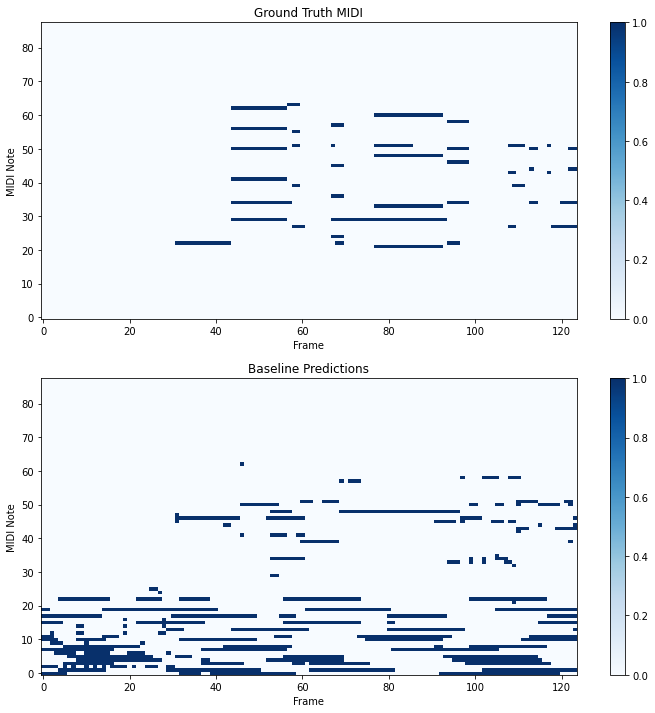

In [8]:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.subplot(211).set_title('Ground Truth MIDI')
plt.subplot(211).set_xlabel('Frame')
plt.subplot(211).set_ylabel('MIDI Note')
plt.imshow(gt, cmap="Blues", aspect="auto", origin='lower') # auto makes each box rectangular
plt.colorbar()
plt.subplot(212)
plt.subplot(212).set_title('Baseline Predictions')
plt.subplot(212).set_xlabel('Frame')
plt.subplot(212).set_ylabel('MIDI Note')
plt.imshow(label, cmap="Blues", aspect="auto", origin='lower') # auto makes each box rectangular
plt.colorbar()
plt.show()